## Depth Estimation


模型: Intel/dpt-large
框架: MindSpore + MindSpore NLP
环境: 香橙派 AIpro（8T/16G） + Ubuntu + MindSpore 2.6.0 + MindSpore NLP 0.4.1
目标: 实现深度估计任务，估计图像中每个像素的深度值

 1. 导入相关库

In [1]:
import mindspore
from mindnlp.transformers import DPTImageProcessor, DPTForDepthEstimation
import numpy as np
from PIL import Image
import requests
print(mindspore.__version__)

/usr/local/miniconda3/lib/python3.9/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/miniconda3/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/usr/local/miniconda3/lib/python3.9/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/miniconda3/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
[WARNING] ME(6864:255086630137888,MainProcess):2025-10-13-19:28:50.742.558 [mindspore/context.py:1402] For 'co

2.6.0


2. 加载图片和dpt-large模型

In [2]:
processor = DPTImageProcessor.from_pretrained("Intel/dpt-large")
model = DPTForDepthEstimation.from_pretrained("Intel/dpt-large").to(dtype=mindspore.float16)

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


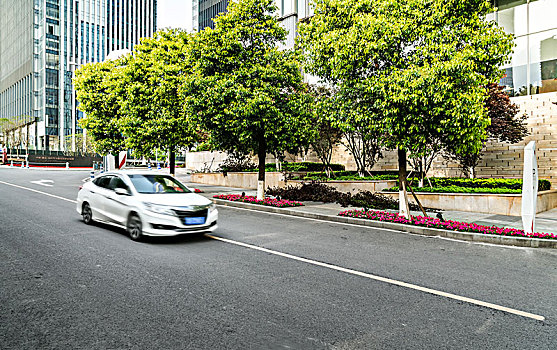

In [3]:
#图片可以自行替换
image = Image.open("testimg.jpg")
image

In [4]:
#将图片转化为向量
inputs = processor(images=image, return_tensors="ms")
# 转为float16适配模型输入
for key in inputs:
    if isinstance(inputs[key], mindspore.Tensor):
        inputs[key] = inputs[key].astype(mindspore.float16)

In [5]:
outputs = model(**inputs)

In [6]:

predicted_depth = outputs.predicted_depth

# 插值到原始大小
prediction = mindspore.ops.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1],
    mode="bicubic",
    align_corners=False,
)


.

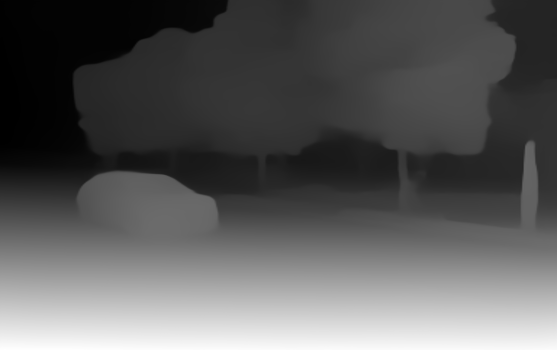

In [7]:
# 可视化输出
output = prediction.squeeze().numpy()
formatted = (output * 255 / np.max(output)).astype("uint8")

depth = Image.fromarray(formatted)
depth